# Test CODS algorithm on same synthetic datasets as in Skomedal & Deceglie (2020) (Paper I)


CODS is a data-driven iterative algorithm for modelling the generated power signal in a PV plant. In particular, it can be used for estimating the degradation rate and soiling profile.
The algorithm takes as input the normalized power signal, and performs the 4 following steps:
1. identification of cleaning events by means of a 9-day rolling median,
2. estimate soiling profile using a Kalman filter,
3. estimate seasonal component by mean of LOESS (STL) decomposition, and
4. estimate degradation rate using year-on-year method.

These four steps are repeated until convergence has been reached. Convergence is measured by the root mean squared error (RMSE) of the daily values of the model versus the observed normalized power or performance index (PI). The convergence criterion is that the relative change in the RMSE from one iteration to the next is smaller than 0.1 %

**Methodology**

- We have, first, generated six different synthetic PI time series (which have a 10-year duration) following the specifications in table II from Paper I. These datasets (which can be found in the Google drive folder - please see `data/CODS/`) have been generetad using [this code](https://github.com/asmunds/simulate_pv_time_series). The latter code generates 10-year time series with the following characteristics:
    - The soiling ratio is generated by randomly selecting 120 cleaning events over a ten year period, and letting the soiling ratio between two cleaning events to be reduced linearly from 1 at a rate randomly sampled from a uniform distribution between $r_{s, min}$ and $r_{s, max}$.
    - The seasonal component is generated as a sine wave centered at 1, with an amplitude $A_{seas}$ and a period of one year.
    - The degradation factor is generated as a linear trend starting at 1 and decreasing at a rate of -0.5%/year.
    - The added noise is gaussian white noise centered at 1 and with standard deviation $\sigma_{noise}$.

- Then, we run the CODS algorithm on 6 different time series. Each time series is characterized by the four parameters: $r_{s, min}$, $r_{s, max}$, $A_{seas}$ and $\sigma_{noise}$ (please see below). Although the generated time series have a 10-year duration, for this analysis we just take the first 5 years in order to have the same duration as our synthetic datasets.
- In the following we summarize the results on the PI, the degradation rate (DR) and the soiling profile estimations.


**Conclusions**
- The RMSE for the DR is smaller than 0.2 %/year for all synthetic time series. The true DR is always contained within the 95% confidence interval (CI).
- The estimated number of cleaning events is larger than the true value of cleaning events.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import rdtools
import time
import pickle
from sklearn.metrics import mean_squared_error

## Visualize synthetic datasets

Although the datasets comprise a 10-year time series. We only take the first 5 years in order to have the same duration as our synthetic datasets

In [4]:
# Load time series
models = ["a", "b", "c", "d", "e", "f"]
df     = {}
for m in models:
    path_to_pkl = "../data/raw/CODS/synthetic_" + m
    df[m] = pd.read_pickle(path_to_pkl)
    df[m] = df[m][df[m].index.year < 2015]

/home/maria/miniconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


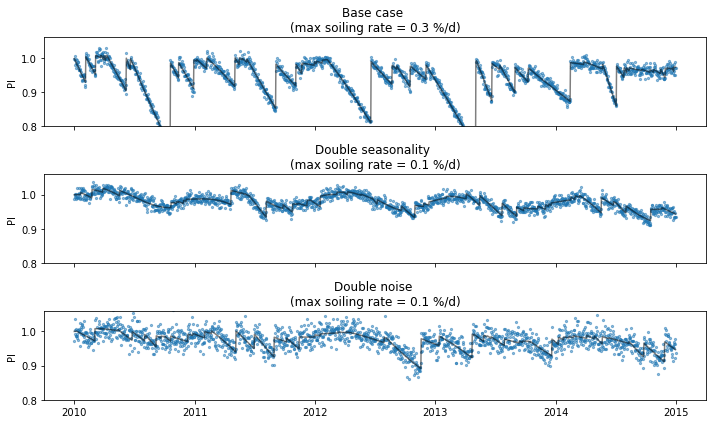

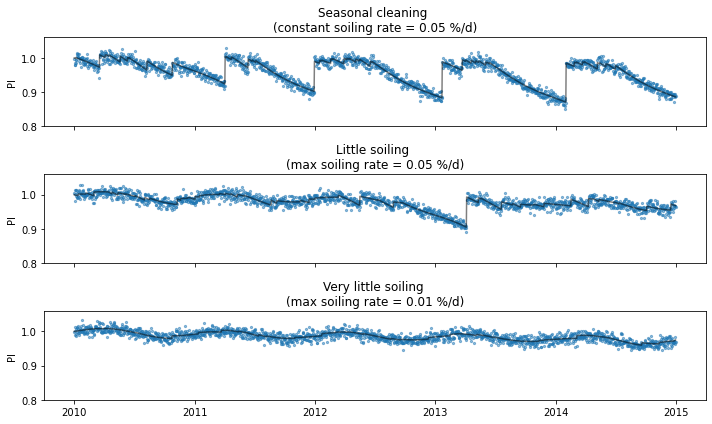

In [3]:
# Plot the 6 different time series used in this analysis
names = ['Base case \n(max soiling rate = 0.3 %/d)',
         'Double seasonality \n(max soiling rate = 0.1 %/d)',
         'Double noise \n(max soiling rate = 0.1 %/d)',
         'Seasonal cleaning \n(constant soiling rate = 0.05 %/d)',
         'Little soiling \n(max soiling rate = 0.05 %/d)',
         'Very little soiling \n(max soiling rate = 0.01 %/d)']
N = len(names)
spn = 5 if N in [5, 9, 10] else (3 if N in [6] else 4)
plt.close('all')
for i in range(N):
    if i%spn==0: fig, ax = plt.subplots(spn, 1, figsize=(10,6), sharex=True) 
    ax[i%spn].scatter(df[models[i]].index, df[models[i]].daily_norm, 5, alpha=.5)
    ax[i%spn].plot(df[models[i]].index, df[models[i]].PI_no_noise, 'k', alpha=.5)
    ax[i%spn].set_ylim(.8,1.06)
    ax[i%spn].set_ylabel("PI")
    ax[i%spn].set_title(names[i])
    plt.tight_layout()

In [4]:
df["a"].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2010-01-01 to 2014-12-31
Freq: D
Data columns (total 11 columns):
day                1826 non-null int64
noise              1826 non-null float64
seasonality        1826 non-null float64
degradation        1826 non-null float64
soiling            1826 non-null float64
cleaning_events    0 non-null object
soiling_rate       1826 non-null float64
PI_no_noise        1826 non-null float64
PI_no_soil         1826 non-null float64
PI_no_degrad       1826 non-null float64
daily_norm         1826 non-null float64
dtypes: float64(9), int64(1), object(1)
memory usage: 171.2+ KB


In [5]:
df["a"].head()

,day,noise,seasonality,degradation,soiling,cleaning_events,soiling_rate,PI_no_noise,PI_no_soil,PI_no_degrad,daily_norm
2010-01-01,0,0.999480,1.000000,1.000000,0.997833,NaN,0.002167,0.997833,0.999480,0.997833,0.997314
2010-01-02,1,0.998888,1.000172,0.999986,0.995666,NaN,0.002167,0.995823,0.999046,0.995837,0.994716
2010-01-03,2,1.010418,1.000344,0.999973,0.993498,NaN,0.002167,0.993813,1.010738,0.993840,1.004166
2010-01-04,3,0.987433,1.000516,0.999959,0.991331,NaN,0.002167,0.991802,0.987901,0.991843,0.979338
2010-01-05,4,1.007454,1.000688,0.999945,0.989164,NaN,0.002167,0.989790,1.008091,0.989844,0.997168


## CODS algorithm

Instead of running the CODS algorithm on each of the 5-year time series (each run takes aroun 10 to 15 min), use the results of the run that can be found in the google drive folder `data/CODS/processed/` and load them. Please see below the save & load results cell.

### Synthetic dataset (a): Base case 
- $r_{s, min}$ = 0 and $r_{s, max}$ = 0.3 %/day
- $R_d$ = -0.5 %\year
- $A_{seas}$ = 1 %
- $\sigma_{noise}$ = 1 %

/home/maria/miniconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'performance index')

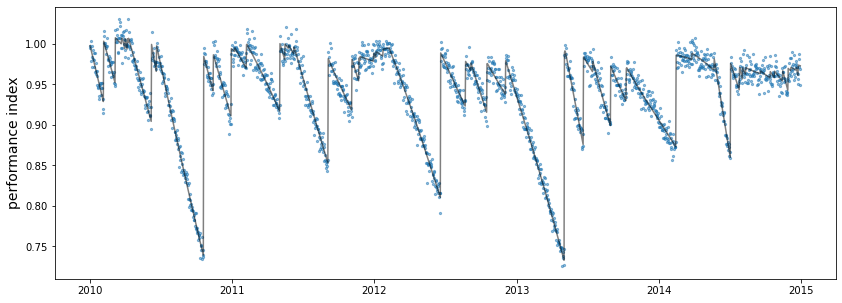

In [5]:
# Obseved PI
daily = df["a"].daily_norm

fig, ax = plt.subplots(figsize=(14, 5)) 
ax.scatter(df["a"].index, df["a"].daily_norm, 5, alpha=.5)
ax.plot(df["a"].index, df["a"].PI_no_noise, 'k', alpha=.5)
#ax.set_ylim(.8,1.06)
ax.set_ylabel("performance index", fontsize=14)

### Estimate degradation rate with year-on-year (yoy) method 

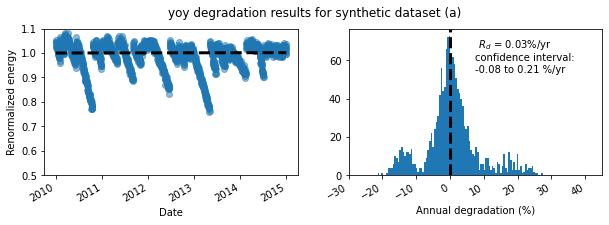

In [70]:
yoy_rd, yoy_ci, yoy_info = rdtools.degradation_year_on_year(daily, confidence_level=68.2)


# Visualize the results
degradation_fig = rdtools.degradation_summary_plots(
    yoy_rd, yoy_ci, yoy_info, daily,
    summary_title='yoy degradation results for synthetic dataset (a)',
    scatter_ymin=0.5, scatter_ymax=1.1,
    hist_xmin=-30, hist_xmax=45, bins=100
)

### CODS results

In [15]:
# TODO CODS is sensitive to outliers. Therefore, in principle, we need to include an intermediate step of outlier 
# filtering before the algorithm is run

Run CODS

In [68]:
# Initialize a CODS instance
cods_instance = rdtools.soiling.cods_analysis(daily)

start_time = time.time()
cods_instance.run_bootstrap(512, verbose=True)
end_time = time.time()
print("--- %s min ---" %((end_time - start_time)/60.))

Initially fitting 16 models
# 16 | Used: 1.7 min | Left: 0.0 min | Progress: [----------------------------->] 100 %
            order    dt        pt     ff      RMSE     SR==1   weights    sss
0   [SR, SC, Rd]  0.25  0.666667   True  0.009573  0.177437  0.060571  False
1   [SR, SC, Rd]  0.25  0.666667  False  0.009412  0.148412  0.063158  False
2   [SR, SC, Rd]  0.25  1.500000   True  0.009605  0.184556  0.060005  False
3   [SR, SC, Rd]  0.25  1.500000  False  0.009501  0.171961  0.061314  False
4   [SR, SC, Rd]  0.75  0.666667   True  0.009376  0.106243  0.065821  False
5   [SR, SC, Rd]  0.75  0.666667  False  0.009376  0.106243  0.065821  False
6   [SR, SC, Rd]  0.75  1.500000   True  0.009480  0.140745  0.063133  False
7   [SR, SC, Rd]  0.75  1.500000  False  0.009480  0.140745  0.063133  False
8   [SC, SR, Rd]  0.25  0.666667   True  0.009523  0.187842  0.060355  False
9   [SC, SR, Rd]  0.25  0.666667  False  0.009436  0.190033  0.060795  False
10  [SC, SR, Rd]  0.25  1.500000   T

/home/maria/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,



Bootstrapping for uncertainty analysis (512 realizations):
# 512 | Used: 11.2 min | Left: 0.0 min | Progress: [----------------------------->] 100 %
Final RMSE: 0.00952
--- 12.991955649852752 min ---


Save & load results

In [44]:
#_file = open("../data/processed/cods_instance_a.pkl", "wb")
#pickle.dump(cods_instance , _file)
_file         = open("../data/processed/cods_instance_a.pkl", "rb")
cods_instance = pickle.load(_file)

In [47]:
result_df.iloc[0:10]

,soiling_ratio,soiling_rates,cleaning_events,seasonal_component,degradation_trend,total_model,residuals,SR_low,SR_high,rates_low,rates_high,bt_soiling_ratio,bt_soiling_rates,seasonal_low,seasonal_high,model_low,model_high
2010-01-01,0.999461,-0.001649,0.000000,1.000179,1.000000,0.994377,0.997674,0.984823,1.000000,-0.003356,-0.000572,0.996414,-0.001888,0.993991,1.005304,0.982847,0.998626
2010-01-02,0.997791,-0.001690,0.004026,1.000313,0.999989,0.992838,0.996618,0.983901,1.000000,-0.002678,0.000000,0.995390,-0.001131,0.994177,1.005440,0.981824,0.998506
2010-01-03,0.996080,-0.001731,0.005987,1.000447,0.999978,0.991257,1.007690,0.982780,1.000000,-0.002765,0.000000,0.994145,-0.001365,0.994361,1.005641,0.980726,0.997203
2010-01-04,0.994330,-0.001770,0.005788,1.000581,0.999967,0.989637,0.984383,0.981060,1.000000,-0.002926,0.000000,0.992656,-0.001608,0.994523,1.005806,0.979695,0.996308
2010-01-05,0.992540,-0.001808,0.013582,1.000715,0.999956,0.987978,1.003988,0.979886,1.000000,-0.002905,0.000000,0.991002,-0.001700,0.994686,1.005920,0.978499,0.995214
2010-01-06,0.990714,-0.001844,0.043613,1.000850,0.999945,0.986282,0.979197,0.978838,0.999808,-0.002953,-0.000061,0.989241,-0.001805,0.994851,1.006032,0.977070,0.993382
2010-01-07,0.988852,-0.001880,0.044803,1.000985,0.999934,0.984550,0.993911,0.977312,0.997483,-0.002963,-0.000821,0.987378,-0.001862,0.995017,1.006142,0.975528,0.991269
2010-01-08,0.986955,-0.001914,0.048384,1.001119,0.999923,0.982782,0.993379,0.975566,0.995394,-0.002873,-0.001038,0.985493,-0.001878,0.995208,1.006250,0.973904,0.989030
2010-01-09,0.985023,-0.001949,0.001889,1.001252,0.999912,0.980978,1.006732,0.973752,0.993645,-0.002810,-0.001134,0.983605,-0.001892,0.995407,1.006355,0.972047,0.986811
2010-01-10,0.983057,-0.001983,0.004095,1.001385,0.999901,0.979139,0.995196,0.971936,0.991641,-0.002737,-0.001185,0.981676,-0.001901,0.995581,1.006458,0.969960,0.984899


**Performance index**

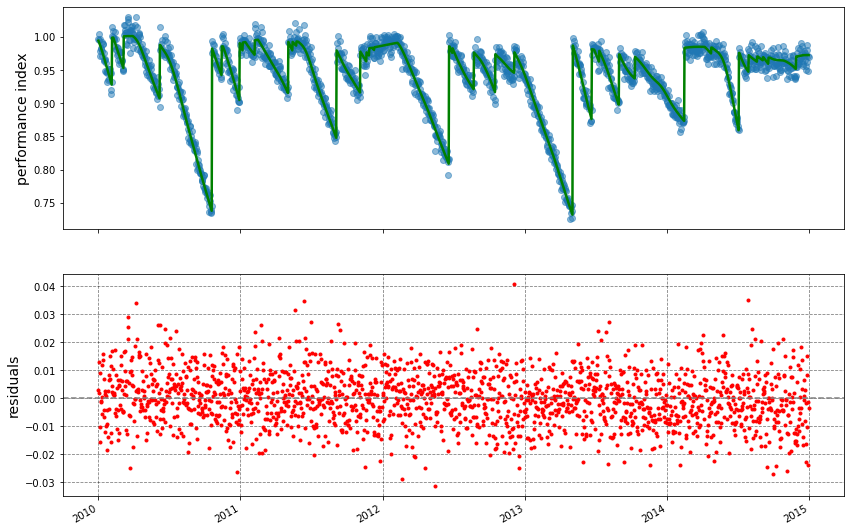

In [50]:
result_df      = cods_instance.result_df
cods_model_fit = result_df.total_model

fig, ax = plt.subplots(2, 1, figsize=(14, 10))
ax[0].plot(daily.index, daily, 'o', alpha = 0.5)
ax[0].plot(cods_model_fit.index, cods_model_fit, color='g', lw=2.5)
#ax[0].set_ylim(0,1.25)
ax[0].set_ylabel("performance index", fontsize=14);
ax[1].plot(daily.index, daily-cods_model_fit, "r.")
ax[1].grid(alpha=0.5, color="k", ls="--")
ax[1].axhline(0., color="grey", ls="--")
ax[1].set_ylabel("residuals", fontsize=14)
fig.autofmt_xdate()

In [101]:
RMSE = mean_squared_error(daily, cods_model_fit, squared=False)
print ("RMSE in the PI is {:.3f}".format(RMSE)) #

RMSE = 0.010


**Degradation rate**

In [107]:
cods_degradation = cods_instance.degradation
print("The P50 (median) degradation rate is {:.2f} %/year".format(cods_degradation[0]))
print("The 95 % confidence interval is ({:.2f}, {:.2f}) %/year".format(cods_degradation[1], cods_degradation[2]))
RMSE = np.sqrt(np.power(-0.5-cods_degradation[0], 2))
print ("RMSE in degradation rate is {:.3f} %/year".format(RMSE))

The P50 (median) degradation rate is -0.40 %/year
The 95 % confidence interval is (-0.57, -0.24) %/year
RMSE in degradation rate is 0.100 %/year


**Soiling profile**

RMSE:  0.004789502195201124


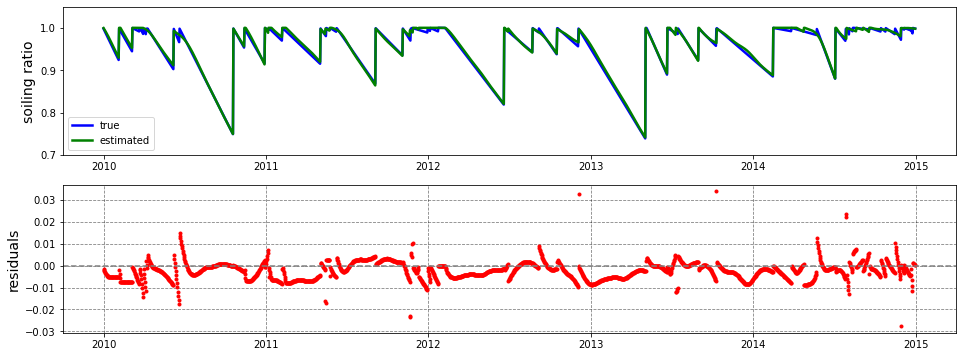

In [11]:
cods_soiling_ratio = result_df.soiling_ratio
soiling            = df["a"].soiling

fig, ax = plt.subplots(2, 1, figsize=(16,6))
ax[0].plot(daily.index, soiling, label="true", color="blue", lw=2.5)
ax[0].plot(cods_soiling_ratio.index, cods_soiling_ratio, color="green", label="estimated", lw=2.5)
ax[0].set_ylabel("soiling ratio", fontsize=14)
ax[0].set_ylim(.7, 1.05)
ax[0].legend()
ax[1].plot(daily.index, soiling - cods_soiling_ratio, "r.")
ax[1].set_ylabel("residuals", fontsize=14)
ax[1].grid(alpha=0.5, color="k", ls="--")
ax[1].axhline(0., color="grey", ls="--")


print("RMSE: ", mean_squared_error(soiling, cods_soiling_ratio, squared=False))

### Synthetic dataset (b): Double seasonality 
- $r_{s, min}$ = 0 and $r_{s, max}$ = 0.1 %/day
- $R_d$ = -0.5 %\year
- $A_{seas}$ = 2 %
- $\sigma_{noise}$ = 1 %

Text(0, 0.5, 'performance index')

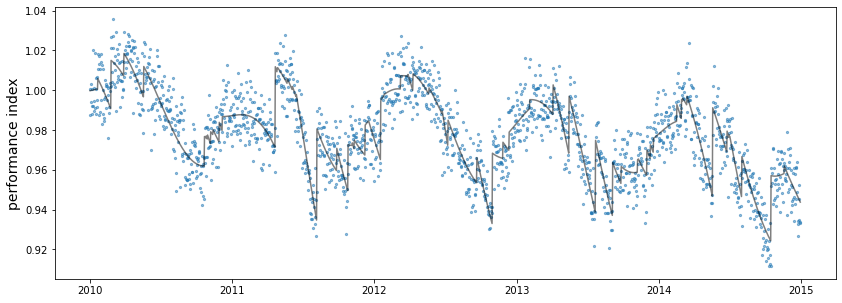

In [6]:
daily = df["b"].daily_norm

fig, ax = plt.subplots(figsize=(14, 5)) 
ax.scatter(df["b"].index, df["b"].daily_norm, 5, alpha=.5)
ax.plot(df["b"].index, df["b"].PI_no_noise, 'k', alpha=.5)
#ax.set_ylim(.8,1.06)
ax.set_ylabel("performance index", fontsize=14)

Run CODS

In [115]:
# Initialize a CODS instance
cods_instance = rdtools.soiling.cods_analysis(daily)

start_time = time.time()
cods_instance.run_bootstrap(512, verbose=True)
end_time = time.time()
print("--- %s min ---" %((end_time - start_time)/60.))

Initially fitting 16 models
# 16 | Used: 1.6 min | Left: 0.0 min | Progress: [----------------------------->] 100 %
            order    dt        pt     ff      RMSE     SR==1   weights    sss
0   [SR, SC, Rd]  0.25  0.666667   True  0.009491  0.202629  0.062959  False
1   [SR, SC, Rd]  0.25  0.666667  False  0.009491  0.202629  0.062959  False
2   [SR, SC, Rd]  0.25  1.500000   True  0.009477  0.217415  0.062285  False
3   [SR, SC, Rd]  0.25  1.500000  False  0.009477  0.217415  0.062285  False
4   [SR, SC, Rd]  0.75  0.666667   True  0.009488  0.190033  0.063644  False
5   [SR, SC, Rd]  0.75  0.666667  False  0.009488  0.190033  0.063644  False
6   [SR, SC, Rd]  0.75  1.500000   True  0.009486  0.193319  0.063482  False
7   [SR, SC, Rd]  0.75  1.500000  False  0.009486  0.193866  0.063454  False
8   [SC, SR, Rd]  0.25  0.666667   True  0.009542  0.220153  0.061721  False
9   [SC, SR, Rd]  0.25  0.666667  False  0.009535  0.220153  0.061763  False
10  [SC, SR, Rd]  0.25  1.500000   T

/home/maria/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,



Bootstrapping for uncertainty analysis (512 realizations):
# 512 | Used: 12.0 min | Left: 0.0 min | Progress: [----------------------------->] 100 %
Final RMSE: 0.00962
--- 13.657129712899525 min ---


In [13]:
# save results & load results
#_file = open("../data/processed/cods_instance_b.pkl", "wb")
#pickle.dump(cods_instance, _file)
_file         = open("../data/processed/cods_instance_b.pkl", "rb")
cods_instance = pickle.load(_file)

**Performance index**

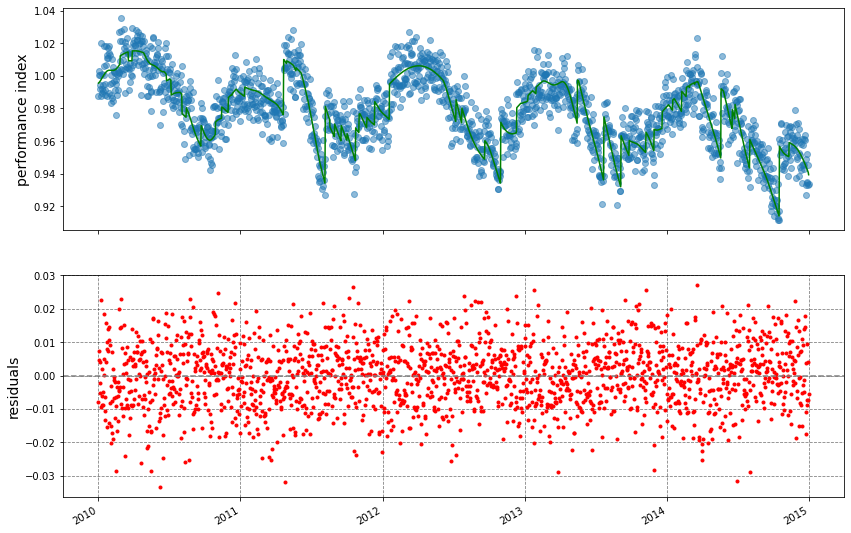

In [14]:
result_df      = cods_instance.result_df
cods_model_fit = result_df.total_model

fig, ax = plt.subplots(2, 1, figsize=(14, 10))
ax[0].plot(daily.index, daily, 'o', alpha = 0.5)
ax[0].plot(cods_model_fit.index, cods_model_fit, color='g')
#ax[0].set_ylim(0,1.25)
ax[0].set_ylabel("performance index", fontsize=14);
ax[1].plot(daily.index, daily-cods_model_fit, "r.")
ax[1].grid(alpha=0.5, color="k", ls="--")
ax[1].axhline(0., color="grey", ls="--")
ax[1].set_ylabel("residuals", fontsize=14)
fig.autofmt_xdate()

In [118]:
RMSE = mean_squared_error(daily, cods_model_fit, squared=False)
print ("RMSE in the PI is {:.3f}".format(RMSE))

RMSE in the PI is 0.010


**Degradation rate**

In [169]:
cods_degradation = cods_instance.degradation
print("The P50 (median) degradation rate is {:.2f} %/year".format(cods_degradation[0]))
print("The 95 % confidence interval is ({:.2f}, {:.2f}) %/year".format(cods_degradation[1], cods_degradation[2]))
RMSE = np.sqrt(np.power(-0.5-cods_degradation[0], 2))
print ("RMSE in degradation rate is {:.3f} %/year".format(RMSE))

The P50 (median) degradation rate is -0.45 %/year
The 95 % confidence interval is (-0.59, -0.31) %/year
RMSE in degradation rate is 0.047 %/year


**Soiling ratio**

RMSE:  0.005361079532625957


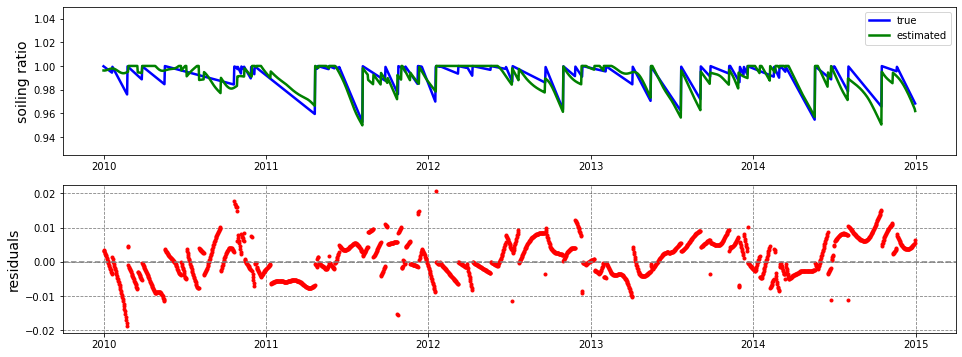

In [16]:
cods_soiling_ratio = result_df.soiling_ratio
soiling            = df["b"].soiling

fig, ax = plt.subplots(2, 1, figsize=(16,6))
ax[0].plot(daily.index, soiling, label="true", color="blue", lw=2.5)
ax[0].plot(cods_soiling_ratio.index, cods_soiling_ratio, color="green", label="estimated", lw=2.5)
ax[0].set_ylabel("soiling ratio", fontsize=14)
ax[0].set_ylim(.925, 1.05)
ax[0].legend()
ax[1].plot(daily.index, soiling - cods_soiling_ratio, "r.")
ax[1].set_ylabel("residuals", fontsize=14)
ax[1].grid(alpha=0.5, color="k", ls="--")
ax[1].axhline(0., color="grey", ls="--")


print("RMSE: ", mean_squared_error(soiling, cods_soiling_ratio, squared=False))

### Synthetic dataset (c): Double noise
- $r_{s, min}$ = 0 and $r_{s, max}$ = 0.1 %/day
- $R_d$ = -0.5 %\year
- $A_{seas}$ = 1 %
- $\sigma_{noise}$ = 2 %

Text(0, 0.5, 'performance index')

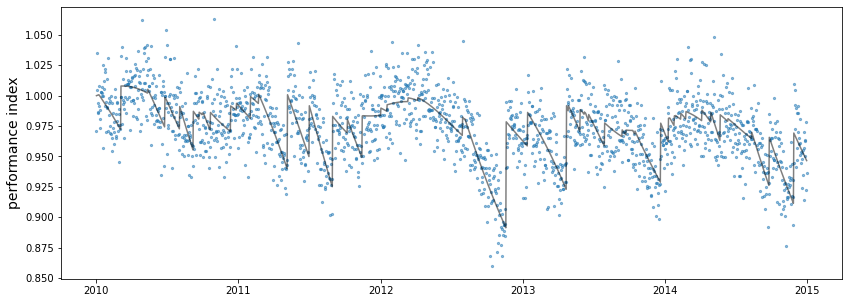

In [7]:
daily = df["c"].daily_norm

fig, ax = plt.subplots(figsize=(14, 5)) 
ax.scatter(df["c"].index, df["c"].daily_norm, 5, alpha=.5)
ax.plot(df["c"].index, df["c"].PI_no_noise, 'k', alpha=.5)
#ax.set_ylim(.8,1.06)
ax.set_ylabel("performance index", fontsize=14)

Run CODS

In [128]:
# Initialize a CODS instance
cods_instance = rdtools.soiling.cods_analysis(daily)

start_time = time.time()
cods_instance.run_bootstrap(512, verbose=True)
end_time = time.time()
print("--- %s min ---" %((end_time - start_time)/60.))

Initially fitting 16 models
# 16 | Used: 1.3 min | Left: 0.0 min | Progress: [----------------------------->] 100 %
            order    dt        pt     ff      RMSE     SR==1   weights    sss
0   [SR, SC, Rd]  0.25  0.666667   True  0.019185  0.169222  0.062496   True
1   [SR, SC, Rd]  0.25  0.666667  False  0.019146  0.175246  0.062302   True
2   [SR, SC, Rd]  0.25  1.500000   True  0.019164  0.192771  0.061329   True
3   [SR, SC, Rd]  0.25  1.500000  False  0.019138  0.183461  0.061895   True
4   [SR, SC, Rd]  0.75  0.666667   True  0.019242  0.151150  0.063289  False
5   [SR, SC, Rd]  0.75  0.666667  False  0.019242  0.151150  0.063289  False
6   [SR, SC, Rd]  0.75  1.500000   True  0.019221  0.159912  0.062880  False
7   [SR, SC, Rd]  0.75  1.500000  False  0.019221  0.159912  0.062880  False
8   [SC, SR, Rd]  0.25  0.666667   True  0.019095  0.148959  0.063895  False
9   [SC, SR, Rd]  0.25  0.666667  False  0.019111  0.156079  0.063448  False
10  [SC, SR, Rd]  0.25  1.500000   T

/home/maria/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,



Bootstrapping for uncertainty analysis (512 realizations):
# 512 | Used: 11.9 min | Left: 0.0 min | Progress: [----------------------------->] 100 %
Final RMSE: 0.01914
--- 13.323974716663361 min ---


In [18]:
# save results & load data
#_file = open("../data/processed/cods_instance_c.pkl", "wb")
#pickle.dump(cods_instance, _file)
_file         = open("../data/processed/cods_instance_c.pkl", "rb")
cods_instance = pickle.load(_file)

**Performance index**

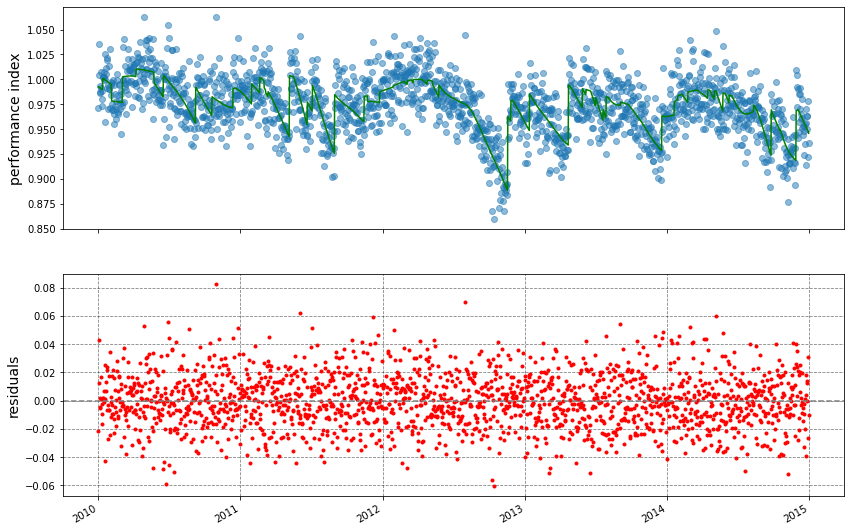

In [19]:
result_df      = cods_instance.result_df
cods_model_fit = result_df.total_model

fig, ax = plt.subplots(2, 1, figsize=(14, 10))
ax[0].plot(daily.index, daily, 'o', alpha = 0.5)
ax[0].plot(cods_model_fit.index, cods_model_fit, color='g')
#ax[0].set_ylim(0,1.25)
ax[0].set_ylabel("performance index", fontsize=14);
ax[1].plot(daily.index, daily-cods_model_fit, "r.")
ax[1].grid(alpha=0.5, color="k", ls="--")
ax[1].axhline(0., color="grey", ls="--")
ax[1].set_ylabel("residuals", fontsize=14)
fig.autofmt_xdate()

In [131]:
RMSE = mean_squared_error(daily, cods_model_fit, squared=False)
print ("RMSE in the PI is {:.3f}".format(RMSE))

RMSE in the PI is 0.019


**Degradation rate**

In [132]:
cods_degradation = cods_instance.degradation
print("The P50 (median) degradation rate is {:.2f} %/year".format(cods_degradation[0]))
print("The 95 % confidence interval is ({:.2f}, {:.2f}) %/year".format(cods_degradation[1], cods_degradation[2]))
RMSE = np.sqrt(np.power(-0.5-cods_degradation[0], 2))
print ("RMSE in degradation rate is {:.3f} %/year".format(RMSE))

The P50 (median) degradation rate is -0.51 %/year
The 95 % confidence interval is (-0.75, -0.30) %/year
RMSE in degradation rate is 0.012 %/year


**Soiling profile**

RMSE:  0.005837718442577915


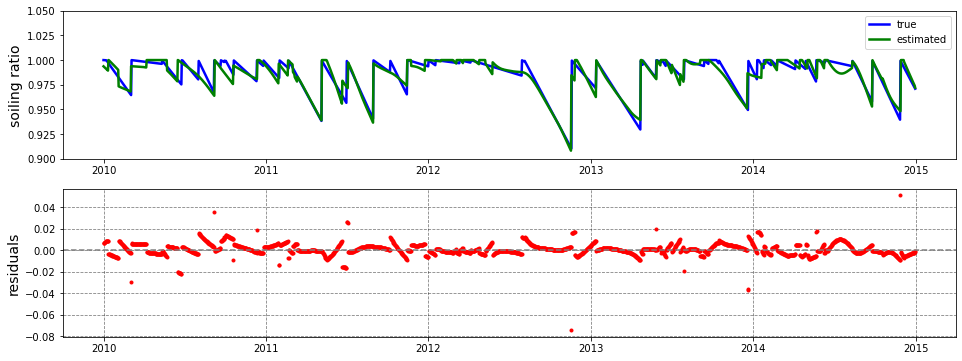

In [20]:
cods_soiling_ratio = result_df.soiling_ratio
soiling            = df["c"].soiling

fig, ax = plt.subplots(2, 1, figsize=(16,6))
ax[0].plot(daily.index, soiling, label="true", color="blue", lw=2.5)
ax[0].plot(cods_soiling_ratio.index, cods_soiling_ratio, color="green", label="estimated", lw=2.5)
ax[0].set_ylabel("soiling ratio", fontsize=14)
ax[0].set_ylim(.9, 1.05)
ax[0].legend()
ax[1].plot(daily.index, soiling - cods_soiling_ratio, "r.")
ax[1].set_ylabel("residuals", fontsize=14)
ax[1].grid(alpha=0.5, color="k", ls="--")
ax[1].axhline(0., color="grey", ls="--")


print("RMSE: ", mean_squared_error(soiling, cods_soiling_ratio, squared=False))

### Synthetic dataset (d): Seasonal cleaning 
- $r_{s, min}$ = 0.05 %/day and $r_{s, max}$ = 0.05 %/day
- $R_d$ = -0.5 %\year
- $A_{seas}$ = 1 %
- $\sigma_{noise}$ = 1 %

Text(0, 0.5, 'performance index')

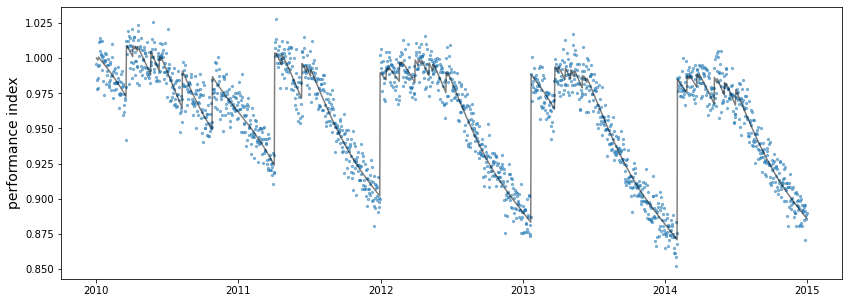

In [8]:
daily = df["d"].daily_norm

fig, ax = plt.subplots(figsize=(14, 5)) 
ax.scatter(df["d"].index, df["d"].daily_norm, 5, alpha=.5)
ax.plot(df["d"].index, df["d"].PI_no_noise, 'k', alpha=.5)
#ax.set_ylim(.8,1.06)
ax.set_ylabel("performance index", fontsize=14)

Run CODS

In [31]:
# Initialize a CODS instance
cods_instance = rdtools.soiling.cods_analysis(daily)

start_time = time.time()
cods_instance.run_bootstrap(512, verbose=True)
end_time = time.time()
print("--- %s min ---" %((end_time - start_time)/60.))

Initially fitting 16 models
# 16 | Used: 2.0 min | Left: 0.0 min | Progress: [----------------------------->] 100 %
            order    dt        pt     ff      RMSE     SR==1   weights    sss
0   [SR, SC, Rd]  0.25  0.666667   True  0.010031  0.275465  0.061256  False
1   [SR, SC, Rd]  0.25  0.666667  False  0.010031  0.275465  0.061256  False
2   [SR, SC, Rd]  0.25  1.500000   True  0.010006  0.259584  0.062184  False
3   [SR, SC, Rd]  0.25  1.500000  False  0.010006  0.259584  0.062184  False
4   [SR, SC, Rd]  0.75  0.666667   True  0.010013  0.292990  0.060531  False
5   [SR, SC, Rd]  0.75  0.666667  False  0.010013  0.292990  0.060531  False
6   [SR, SC, Rd]  0.75  1.500000   True  0.010212  0.311062  0.058538  False
7   [SR, SC, Rd]  0.75  1.500000  False  0.010212  0.311062  0.058538  False
8   [SC, SR, Rd]  0.25  0.666667   True  0.009922  0.248631  0.063260  False
9   [SC, SR, Rd]  0.25  0.666667  False  0.009922  0.248631  0.063260  False
10  [SC, SR, Rd]  0.25  1.500000   T

/home/maria/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,



Bootstrapping for uncertainty analysis (512 realizations):
# 512 | Used: 12.0 min | Left: 0.0 min | Progress: [----------------------------->] 100 %
Final RMSE: 0.00971
--- 14.104391916592915 min ---


In [32]:
# save results & load data
#_file = open("../data/processed/cods_instance_d.pkl", "wb")
#pickle.dump(cods_instance, _file)
_file         = open("../data/processed/cods_instance_d.pkl", "rb")
cods_instance = pickle.load(_file)

**Performance index**

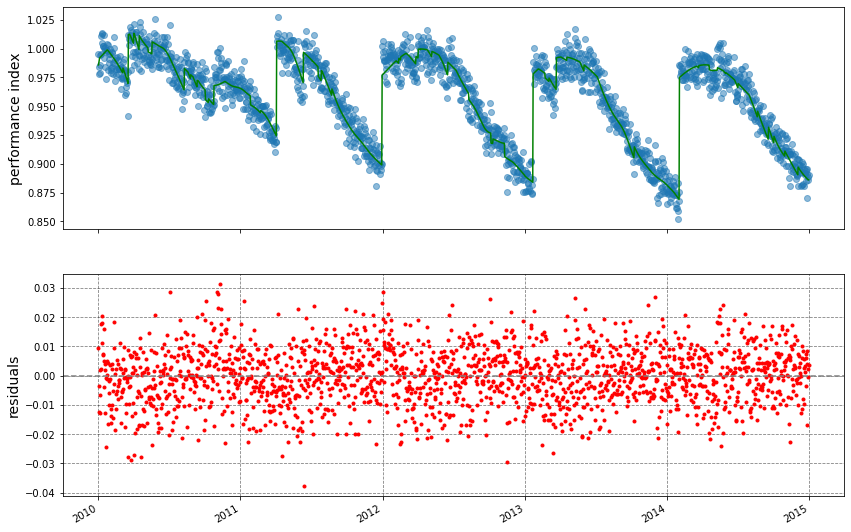

In [33]:
result_df      = cods_instance.result_df
cods_model_fit = result_df.total_model

fig, ax = plt.subplots(2, 1, figsize=(14, 10))
ax[0].plot(daily.index, daily, 'o', alpha = 0.5)
ax[0].plot(cods_model_fit.index, cods_model_fit, color='g')
#ax[0].set_ylim(0,1.25)
ax[0].set_ylabel("performance index", fontsize=14);
ax[1].plot(daily.index, daily-cods_model_fit, "r.")
ax[1].grid(alpha=0.5, color="k", ls="--")
ax[1].axhline(0., color="grey", ls="--")
ax[1].set_ylabel("residuals", fontsize=14)
fig.autofmt_xdate()

In [34]:
RMSE = mean_squared_error(daily, cods_model_fit, squared=False)
print ("RMSE in the PI is {:.3f}".format(RMSE))

RMSE in the PI is 0.010


**Degradation rate**

In [35]:
cods_degradation = cods_instance.degradation
print("The P50 (median) degradation rate is {:.2f} %/year".format(cods_degradation[0]))
print("The 95 % confidence interval is ({:.2f}, {:.2f}) %/year".format(cods_degradation[1], cods_degradation[2]))
RMSE = np.sqrt(np.power(-0.5-cods_degradation[0], 2))
print ("RMSE in degradation rate is {:.3f} %/year".format(RMSE))

The P50 (median) degradation rate is -0.68 %/year
The 95 % confidence interval is (-0.89, -0.44) %/year
RMSE in degradation rate is 0.177 %/year


**Soiling profile**

RMSE:  0.01194367368399204


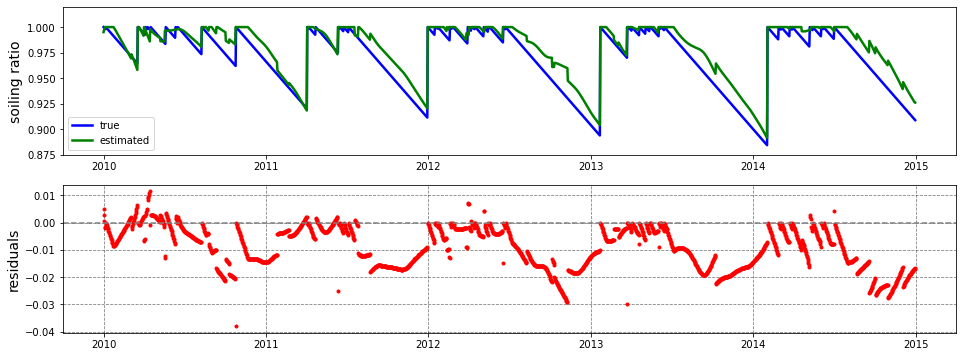

In [38]:
cods_soiling_ratio = result_df.soiling_ratio
soiling            = df["d"].soiling

fig, ax = plt.subplots(2, 1, figsize=(16,6))
ax[0].plot(daily.index, soiling, label="true", color="blue", lw=2.5)
ax[0].plot(cods_soiling_ratio.index, cods_soiling_ratio, color="green", label="estimated", lw=2.5)
ax[0].set_ylabel("soiling ratio", fontsize=14)
ax[0].set_ylim(.875, 1.02)
ax[0].legend()
ax[1].plot(daily.index, soiling - cods_soiling_ratio, "r.")
ax[1].set_ylabel("residuals", fontsize=14)
ax[1].grid(alpha=0.5, color="k", ls="--")
ax[1].axhline(0., color="grey", ls="--")


print("RMSE: ", mean_squared_error(soiling, cods_soiling_ratio, squared=False))

### Synthetic dataset (e): Little soiling
- $r_{s, min}$ = 0 and $r_{s, max}$ = 0.05 %/day
- $R_d$ = -0.5 %\year
- $A_{seas}$ = 1 %
- $\sigma_{noise}$ = 1 %

Text(0, 0.5, 'performance index')

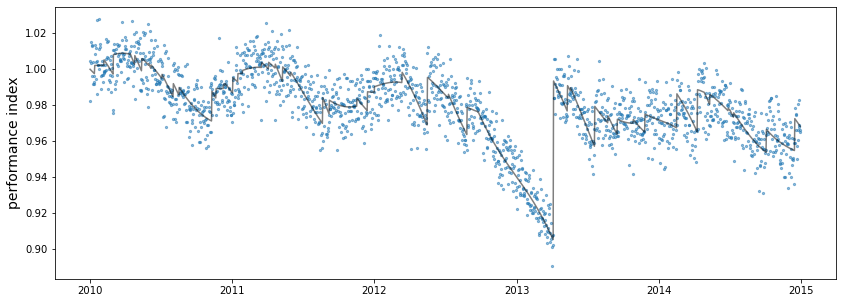

In [9]:
daily = df["e"].daily_norm

fig, ax = plt.subplots(figsize=(14, 5)) 
ax.scatter(df["e"].index, df["e"].daily_norm, 5, alpha=.5)
ax.plot(df["e"].index, df["e"].PI_no_noise, 'k', alpha=.5)
#ax.set_ylim(.8,1.06)
ax.set_ylabel("performance index", fontsize=14)

Run CODS

In [150]:
# Initialize a CODS instance
cods_instance = rdtools.soiling.cods_analysis(daily)

start_time = time.time()
cods_instance.run_bootstrap(512, verbose=True)
end_time = time.time()
print("--- %s min ---" %((end_time - start_time)/60.))

Initially fitting 16 models
# 16 | Used: 1.6 min | Left: 0.0 min | Progress: [----------------------------->] 100 %
            order    dt        pt     ff      RMSE     SR==1   weights    sss
0   [SR, SC, Rd]  0.25  0.666667   True  0.009585  0.156079  0.064769  False
1   [SR, SC, Rd]  0.25  0.666667  False  0.009585  0.156079  0.064769  False
2   [SR, SC, Rd]  0.25  1.500000   True  0.009651  0.250274  0.059482  False
3   [SR, SC, Rd]  0.25  1.500000  False  0.009651  0.250274  0.059482  False
4   [SR, SC, Rd]  0.75  0.666667   True  0.009608  0.136364  0.065737  False
5   [SR, SC, Rd]  0.75  0.666667  False  0.009608  0.136364  0.065737  False
6   [SR, SC, Rd]  0.75  1.500000   True  0.009662  0.215225  0.061130  False
7   [SR, SC, Rd]  0.75  1.500000  False  0.009662  0.215225  0.061130  False
8   [SC, SR, Rd]  0.25  0.666667   True  0.009607  0.212486  0.061618  False
9   [SC, SR, Rd]  0.25  0.666667  False  0.009607  0.212486  0.061618  False
10  [SC, SR, Rd]  0.25  1.500000   T

/home/maria/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,



Bootstrapping for uncertainty analysis (512 realizations):
# 512 | Used: 12.0 min | Left: 0.0 min | Progress: [----------------------------->] 100 %
Final RMSE: 0.00964
--- 13.70665999253591 min ---


In [40]:
# save results & load data
#_file = open("../data/processed/cods_instance_e.pkl", "wb")
#pickle.dump(cods_instance, _file)
_file         = open("../data/processed/cods_instance_e.pkl", "rb")
cods_instance = pickle.load(_file)

**Performance index**

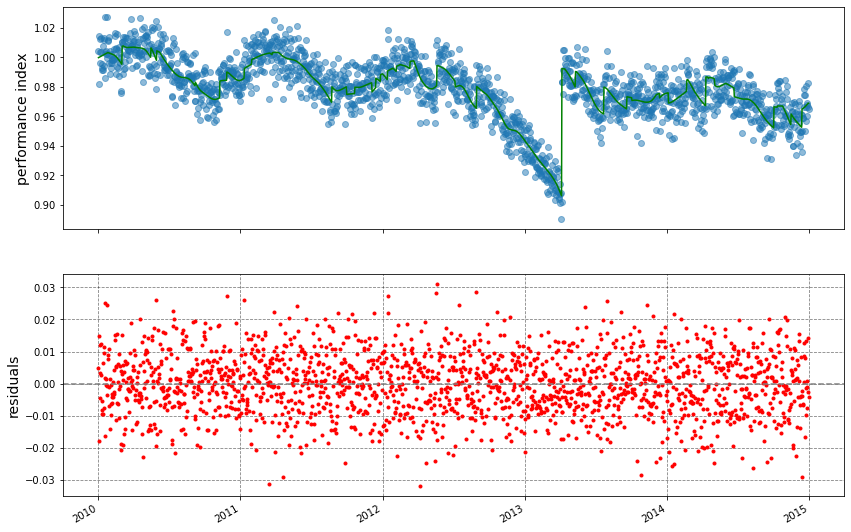

In [41]:
result_df      = cods_instance.result_df
cods_model_fit = result_df.total_model

fig, ax = plt.subplots(2, 1, figsize=(14, 10))
ax[0].plot(daily.index, daily, 'o', alpha = 0.5)
ax[0].plot(cods_model_fit.index, cods_model_fit, color='g')
#ax[0].set_ylim(0,1.25)
ax[0].set_ylabel("performance index", fontsize=14);
ax[1].plot(daily.index, daily-cods_model_fit, "r.")
ax[1].grid(alpha=0.5, color="k", ls="--")
ax[1].axhline(0., color="grey", ls="--")
ax[1].set_ylabel("residuals", fontsize=14)
fig.autofmt_xdate()

In [153]:
RMSE = mean_squared_error(daily, cods_model_fit, squared=False)
print ("RMSE in the PI is {:.3f}".format(RMSE))

RMSE in the PI is 0.010


**Degradation rate**

In [154]:
cods_degradation = cods_instance.degradation
print("The P50 (median) degradation rate is {:.2f} %/year".format(cods_degradation[0]))
print("The 95 % confidence interval is ({:.2f}, {:.2f}) %/year".format(cods_degradation[1], cods_degradation[2]))
RMSE = np.sqrt(np.power(-0.5-cods_degradation[0], 2))
print ("RMSE in degradation rate is {:.3f} %/year".format(RMSE))

The P50 (median) degradation rate is -0.54 %/year
The 95 % confidence interval is (-0.67, -0.42) %/year
RMSE in degradation rate is 0.044 %/year


**Soiling profile**

RMSE:  0.0033429304756707745


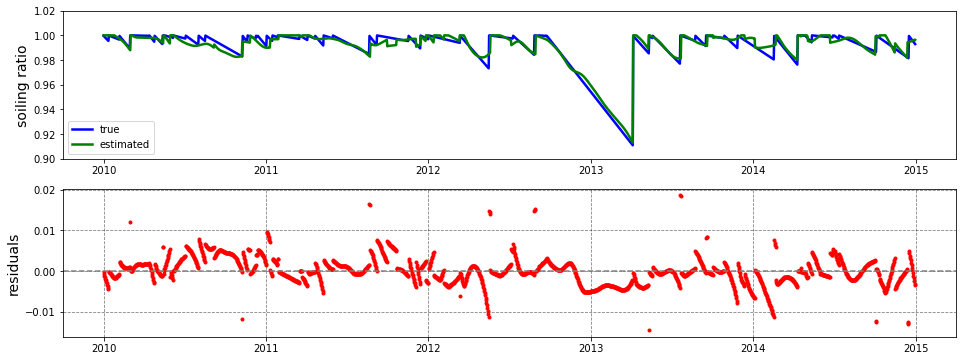

In [42]:
cods_soiling_ratio = result_df.soiling_ratio
soiling            = df["e"].soiling

fig, ax = plt.subplots(2, 1, figsize=(16,6))
ax[0].plot(daily.index, soiling, label="true", color="blue", lw=2.5)
ax[0].plot(cods_soiling_ratio.index, cods_soiling_ratio, color="green", label="estimated", lw=2.5)
ax[0].set_ylabel("soiling ratio", fontsize=14)
ax[0].set_ylim(.9, 1.02)
ax[0].legend()
ax[1].plot(daily.index, soiling - cods_soiling_ratio, "r.")
ax[1].set_ylabel("residuals", fontsize=14)
ax[1].grid(alpha=0.5, color="k", ls="--")
ax[1].axhline(0., color="grey", ls="--")


print("RMSE: ", mean_squared_error(soiling, cods_soiling_ratio, squared=False))

### Synthetic dataset (f): Very little soiling
- $r_{s, min}$ = 0 and $r_{s, max}$ = 0.01 %/day
- $R_d$ = -0.5 %/year
- $A_{seas}$ = 1 %
- $\sigma_{noise}$ = 1 %

Text(0, 0.5, 'performance index')

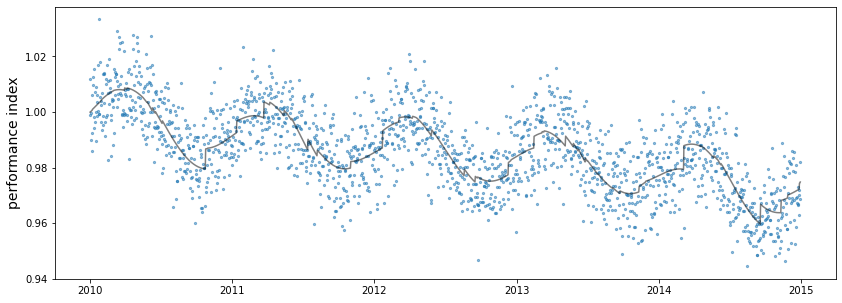

In [11]:
daily = df["f"].daily_norm

fig, ax = plt.subplots(figsize=(14, 5)) 
ax.scatter(df["f"].index, df["f"].daily_norm, 5, alpha=.5)
ax.plot(df["f"].index, df["f"].PI_no_noise, 'k', alpha=.5)
#ax.set_ylim(.8,1.06)
ax.set_ylabel("performance index", fontsize=14)

Run CODS

In [157]:
# Initialize a CODS instance
cods_instance = rdtools.soiling.cods_analysis(daily)

start_time = time.time()
cods_instance.run_bootstrap(512, verbose=True)
end_time = time.time()
print("--- %s min ---" %((end_time - start_time)/60.))

Initially fitting 16 models
# 16 | Used: 1.4 min | Left: 0.0 min | Progress: [----------------------------->] 100 %
            order    dt        pt     ff      RMSE     SR==1   weights   sss
0   [SR, SC, Rd]  0.25  0.666667   True  0.009256  0.152793  0.062424  True
1   [SR, SC, Rd]  0.25  0.666667  False  0.009267  0.160460  0.061939  True
2   [SR, SC, Rd]  0.25  1.500000   True  0.009245  0.161555  0.062027  True
3   [SR, SC, Rd]  0.25  1.500000  False  0.009246  0.161008  0.062050  True
4   [SR, SC, Rd]  0.75  0.666667   True  0.009300  0.123220  0.063763  True
5   [SR, SC, Rd]  0.75  0.666667  False  0.009306  0.126506  0.063538  True
6   [SR, SC, Rd]  0.75  1.500000   True  0.009277  0.143483  0.062791  True
7   [SR, SC, Rd]  0.75  1.500000  False  0.009277  0.143483  0.062791  True
8   [SC, SR, Rd]  0.25  0.666667   True  0.009285  0.141840  0.062827  True
9   [SC, SR, Rd]  0.25  0.666667  False  0.009285  0.141840  0.062827  True
10  [SC, SR, Rd]  0.25  1.500000   True  0.0092